In [ ]:
# For running in colab
from google.colab import drive
drive.mount('/content/drive/')

import os
import sys

# TODO: Fill in the Google Drive path where you uploaded the assignment, it should be under CS354-Assignments-2022/netid-A1
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'CS6540-F24/Project' # change this directory to yours
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

sys.path.append(GOOGLE_DRIVE_PATH)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
['constants.py', 'catagolue.parquet', 'world_catagolue.parquet', 'image_classifier.py', 'generate_worlds.py', 'segment.ipynb', '__pycache__']


In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm import trange

In [54]:
from generate_worlds import load_world_df, truncate_labels, visualize_world
from pathlib import Path
import polars as pl

INPUT_PATH = Path('/content/drive/MyDrive/'+GOOGLE_DRIVE_PATH_AFTER_MYDRIVE+'/world_catagolue.parquet')
CATEGORY_COUNT = 4
# Load in the data into trainset and testset
def load_and_process_data():
  if INPUT_PATH.exists():
      df = pl.read_parquet(INPUT_PATH)
  else:
      print('No worlds file')
      return None

  worlds = []
  labels = []

  for idx, row in enumerate(df.rows(named=True)):
    if idx % 2 == 0:
      print(f'{idx}/{len(df)}', end='')
    else:
      print('',end='\r')

    world = row['world pattern']
    label = row['label']

    new_label = truncate_labels(world, label, pad_size = 2)

    worlds.append(world)
    labels.append(new_label)


  return worlds, labels

ws, ls = load_and_process_data()

torch.Size([700, 4, 64, 64])

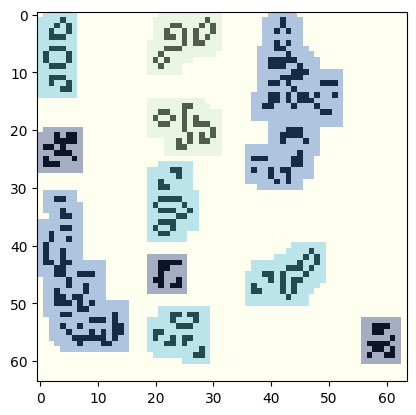

In [74]:
# Load in the training and testing data into distinct tensors

# Maybe get to  transforms later
# import torchvision.transforms as transforms

train_data = torch.Tensor(ws[0:700])
train_labels = torch.Tensor(ls[0:700])

test_data = torch.Tensor(ws[700:])
test_labels = torch.Tensor(ls[700:])


d = train_data[10]
l = train_labels[10]
visualize_world(d, l)

train_labels.shape

In [75]:
from pathlib import Path
import warnings


# Torch fires this warning on every call to load_state_dict()
warnings.filterwarnings('ignore', category=UserWarning, message='TypedStorage is deprecated')

# Code adapted from the work done by user 'Nikdenof' from Medium
# https://medium.com/@nikdenof/segnet-from-scratch-using-pytorch-3fe9b4527239

# Which is in turn based on the paper
# SegNet: A Deep Convolutional Encoder-Decoder Architecture for Image Segmentation
# https://arxiv.org/pdf/1511.00561
class ConvBlock(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
    super(ConvBlock, self).__init__()
    self.stack = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )

  def forward(self, x):
    return self.stack(x)

class EncoderBlock(nn.Module):
  # Creates an encoder block with [depth] convolution layers
  def __init__(self, in_channels, out_channels, depth=2, kernel_size=3, padding=1):
    super(EncoderBlock, self).__init__()
    self.layers = nn.ModuleList()
    for i in range(depth):
      self.layers.append(ConvBlock(in_channels, out_channels, kernel_size, padding))
      in_channels = out_channels
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

  def forward(self, x):
    for layer in self.layers:
      x = layer(x)
    x, ind = self.pool(x)
    return x, ind

class DecoderBlock(nn.Module):
  def __init__(self, in_channels, out_channels, depth=2, kernel_size=3, padding=1, classification=False):
    super(DecoderBlock, self).__init__()
    self.unpool = nn.MaxUnpool2d(kernel_size=2, stride=2)
    self.layers = nn.ModuleList()
    # Recall that this is the decoder, so out_channels > in_channels
    for i in range(depth):
      if i == depth - 1:
        if classification:
          # Don't need BN or ReLU on the final layer
          self.layers.append(nn.Conv2d(in_channels, out_channels, kernel_size, padding))
        else:
          # Expand at the final layer of the block
          self.layers.append(ConvBlock(in_channels, out_channels, kernel_size, padding))
      else:
        self.layers.append(ConvBlock(in_channels, in_channels, kernel_size, padding))

  def forward(self, x, ind):
    x = self.unpool(x, ind)
    for layer in self.layers:
      x = layer(x)
    return x

class SegNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=64):
        super(SegNet, self).__init__()

        # Encoder
        self.enc0 = EncoderBlock(in_channels, features)
        self.enc1 = EncoderBlock(features, features * 2)
        self.enc2 = EncoderBlock(features * 2, features * 4, depth=3)
        self.enc3 = EncoderBlock(features * 4, features * 8, depth=3)

        # Bottleneck
        self.bottleneck_enc = EncoderBlock(features * 8, features * 8, depth=3)
        self.bottleneck_dec = DecoderBlock(features * 8, features * 8, depth=3)

        # Decoder
        self.dec0 = DecoderBlock(features * 8, features * 4, depth=3)
        self.dec1 = DecoderBlock(features * 4, features * 2, depth=3)
        self.dec2 = DecoderBlock(features * 2, features)
        self.dec3 = DecoderBlock(features, out_channels, classification=True) # Final layer classifies

    def forward(self, x):
        # encoder
        e0, ind0 = self.enc0(x)
        e1, ind1 = self.enc1(e0)
        e2, ind2 = self.enc2(e1)
        e3, ind3 = self.enc3(e2)

        # bottleneck
        b0, indb = self.bottleneck_enc(e3)
        b1 = self.bottleneck_dec(b0, indb)

        # decoder
        d0 = self.dec0(b1, ind3)
        d1 = self.dec1(d0, ind2)
        d2 = self.dec2(d1, ind1)

        # classification layer
        output = self.dec3(d2, ind0)
        return output

In [80]:
# To use GPU, you can set it in the menu "Runtime" - > "change runtime type"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Put the network on the GPU
segnet = SegNet(in_channels = 1, out_channels = 4)
#segnet = SegNet.to(device)

# This likely needs to change to some form of IoU
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(segnet.parameters(), lr = 0.001)

cpu


In [81]:
# train MobileNet here.
segnet.train()

for epoch in range(10):  # Repeat multiple rounds
    for i, (inputs, labels) in enumerate(zip(train_data, train_labels)):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # add your code here ...
        optimizer.zero_grad()
        output = segnet(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        # Output statistics
        if i % 100 == 0:
            print('Epoch: %d Minibatch: %5d loss: %.3f' %(epoch + 1, i + 1, loss.item()))

print('Finished Training')

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [64, 64]